In [30]:
import spikeinterface.qualitymetrics as sqm
import spikeinterface.preprocessing as sp
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import probeinterface as pi

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Load data
recording = se.read_openephys(
    "data/openephys/2023-08-23_15-56-05"    
)

# Set probe
probe = pi.get_probe('cambridgeneurotech', 'ASSY-236-H5')
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
recording = recording.set_probe(probe)

print(recording)

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB


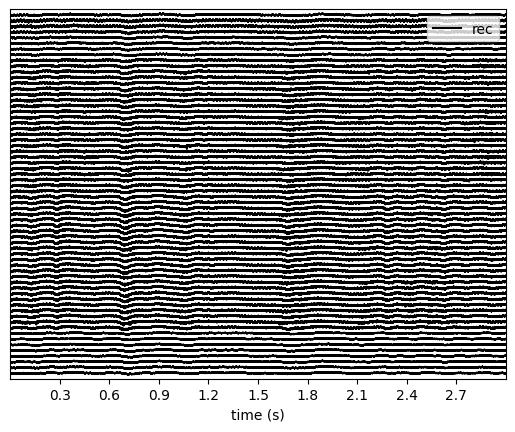

In [7]:
_ = sw.plot_traces(recording, time_range=(0, 3))

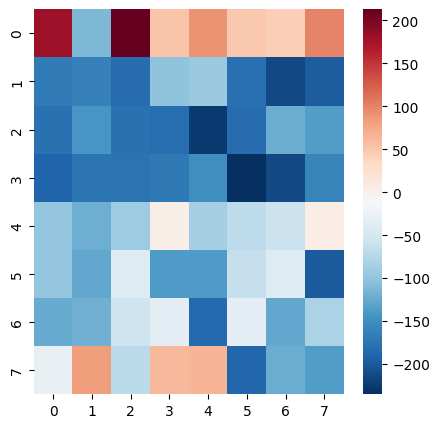

In [12]:
_, ax = plt.subplots(figsize=(5, 5))

start = 30000
end = 30100
traces_raw = recording.get_traces(
    start_frame=start, 
    end_frame=end
)

traces = np.reshape(traces_raw, (100, 8, 8))
sns.heatmap(traces[50, :, :], cmap='RdBu_r')
plt.show()

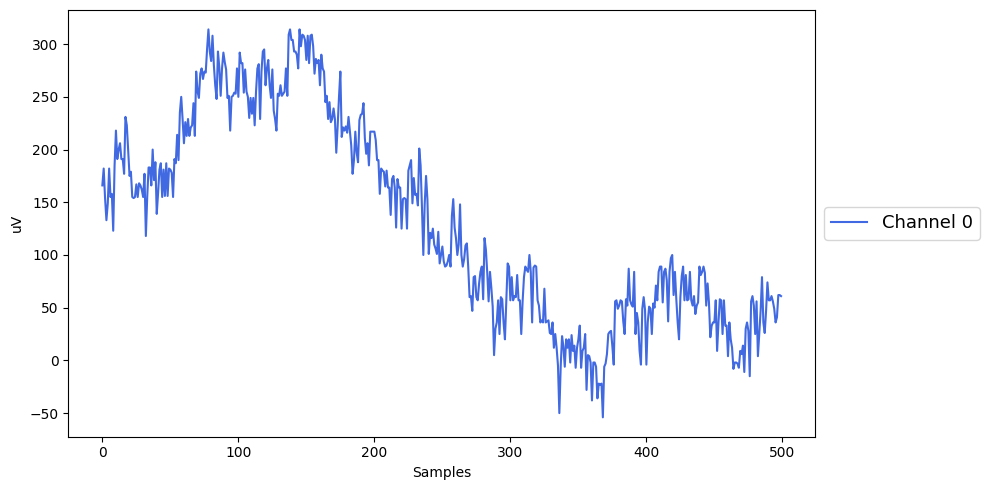

In [13]:
_, ax = plt.subplots(figsize=(10, 5))

start = 30000
end = 30500
traces = recording.get_traces( 
    start_frame=start, 
    end_frame=end
)

n_channel = 0
ax.plot(traces[:, n_channel], label=f'Channel {n_channel}', c='royalblue')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

ax.set_xlabel('Samples')
ax.set_ylabel('uV')

plt.tight_layout()
plt.show()

# Preprocessing

In [15]:
recording_filt = sp.bandpass_filter(
    recording, freq_min=300, freq_max=9000
)
recording_cmr = sp.common_reference(
    recording_filt, reference='global', operator='median'
)

# Sorters

In [17]:
sorter = 'spykingcircus2'
ss.run_sorter(
    sorter_name=sorter,
    recording=recording_cmr,
    output_folder=f"results/{sorter}",
    remove_existing_folder=True,
    verbose=True
)

detect peaks using locally_exclusive with n_jobs = 8 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 112246 peaks in total
We kept 112246 peaks for clustering
extracting features with n_jobs = 8 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

We found 82 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\roque\anaconda3\envs\spikesorting\lib\site-packages\spikeinterface\core\baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We kept 73 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 8 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 294476 spikes
spykingcircus2 run time 553.45s


NumpyFolderSorting: 73 units - 1 segments - 30.0kHz

# Extract Wavorms

In [21]:
# Load sorting results

sorting = ss.read_sorter_folder(
    "results/spykingcircus2", 
)
print(sorting)

NumpyFolderSorting: 73 units - 1 segments - 30.0kHz


In [28]:
we = sc.extract_waveforms(
    recording_cmr, sorting, 
    folder="results/spykingcircus2/waveforms",                       
    sparse=False, 
    overwrite=True
)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 73 units - 1 segments
  before:30 after:60 n_per_units:500


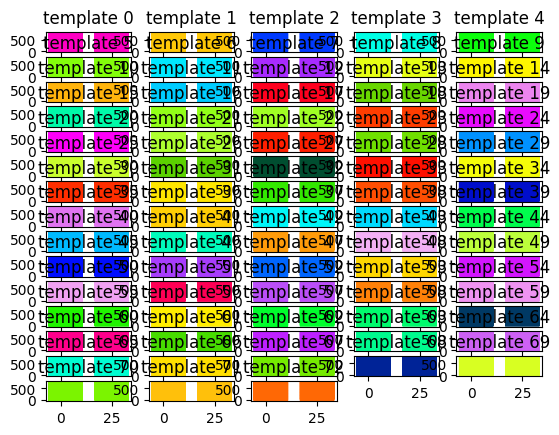

In [29]:
_ = sw.plot_unit_templates(we)

# Metrics

In [31]:
metric_names = sqm.get_quality_metric_list()
qm = sqm.compute_quality_metrics(
    we, metric_names=metric_names, 
    verbose=True,  
)

Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median


C:\Users\roque\anaconda3\envs\spikesorting\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:842: UserWarning: Units [0, 8, 15, 26, 58] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
C:\Users\roque\anaconda3\envs\spikesorting\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:696: UserWarning: 
  warnings.warn("")


Computing amplitude_cv
Computing synchrony
Computing firing_range
Computing drift


C:\Users\roque\anaconda3\envs\spikesorting\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:982: UserWarning: The drift metrics require the `spike_locations` waveform extension. Use the `postprocessing.compute_spike_locations()` function. Drift metrics will be set to NaN
  warnings.warn(


In [33]:
qm

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,266.0,0.886667,1.0,50.194626,0.000000,0.0,0.000000,0.0,NaN,NaN,316.679993,NaN,0.093985,0.000000,0.0,2.00,NaN,NaN,NaN
1,2875.0,9.583333,1.0,2.724765,0.713800,59.0,1.000000,56.0,NaN,0.000518,24.179998,NaN,0.025391,0.000000,0.0,8.27,NaN,NaN,NaN
2,1856.0,6.186667,1.0,2.520345,2.990069,103.0,1.000000,65.0,NaN,0.001856,23.594999,NaN,0.019397,0.000000,0.0,8.02,NaN,NaN,NaN
3,3362.0,11.206667,1.0,4.104538,2.831096,320.0,1.000000,256.0,NaN,0.002343,21.059999,NaN,0.059786,0.000000,0.0,7.43,NaN,NaN,NaN
4,3818.0,12.726667,1.0,5.736215,4.795185,699.0,1.000000,692.0,NaN,0.002343,34.320000,NaN,0.082766,0.000000,0.0,8.65,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1072.0,3.573333,1.0,19.634207,0.087018,1.0,0.140381,1.0,0.295,0.002920,113.977493,NaN,0.052239,0.000000,0.0,3.02,NaN,NaN,NaN
69,5758.0,19.193333,1.0,7.116743,1.830819,607.0,1.000000,429.0,NaN,0.003588,37.244999,NaN,0.091004,0.000174,0.0,9.23,NaN,NaN,NaN
70,6120.0,20.400000,1.0,4.295285,1.828891,685.0,1.000000,526.0,NaN,0.005606,24.082499,NaN,0.079902,0.000327,0.0,10.01,NaN,NaN,NaN
71,2696.0,8.986667,1.0,6.457565,1.251992,91.0,1.000000,61.0,NaN,0.011385,43.094997,NaN,0.075668,0.000000,0.0,7.45,NaN,NaN,NaN


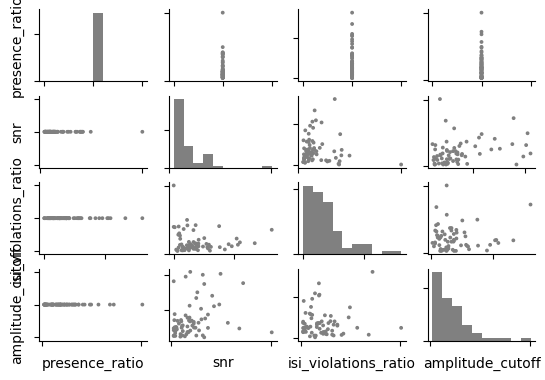

In [35]:
sw.plot_quality_metrics(
    we, 
    include_metrics=[
        "amplitude_cutoff", "presence_ratio", 
        "isi_violations_ratio", "snr"
    ]
)
plt.show()